In [1]:
import Functions_data_analysis as fda
import Functions_load_output as flo
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import matplotlib.path as mpath
from scipy import stats, signal
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [2]:
# Get recon data with anom ref 1979-2005

recon_dir = 'Climate_Data/LMR_output/'
# pace_recon = 'PACE_super_GKO1_all_linPSM_1mc_1900_2005_GISBrom_1880_2019_v10_sst'
pace2_recon = 'PAC_PACE2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom'
lme_recon = 'iCESM_LME_GKO1_linPSM_1mc_1800_2005_v10'
lens2_recon='LENS2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom'

recons = [lme_recon, lens2_recon, pace2_recon]
labs = ['CESM1-LME recon','CESM2-LENS recon','CESM2-PACE recon']


def get_recon_anom_data(recon_name,vname):
    """
    Gets gridded recon data from 1900 to 2005 in anomalies relative to 1979-2005.
    """
    recon_ds = xr.open_dataset(recon_dir+recon+'_'+vname+'.nc')
    recon_data = recon_ds.get(vname)
    recon_data_20th = recon_data.sel(time = slice(1900,2005))

    ref_data = recon_data.sel(time=slice(1979,2005)).mean(dim='time')
    recon_data_anom = recon_data_20th - ref_data

    recon_data_anom = recon_data_anom.squeeze()

    return recon_data_anom


recon_tas_dict = {}
recon_psl_dict = {}
recon_u10_dict = {}
recon_v10_dict = {}

for recon,lab in zip(recons, labs):

    recon_tas_dict[lab] = get_recon_anom_data(recon, 'tas')
    recon_psl_dict[lab] = get_recon_anom_data(recon, 'psl')/100
    recon_u10_dict[lab] = get_recon_anom_data(recon, 'u10')
    recon_v10_dict[lab] = get_recon_anom_data(recon, 'v10')

    

In [3]:
# Set up stats functions

def calc_corr(x,y):
    """
    x and y can be lists or arrays
    """
    #detrend data first
    x = signal.detrend(x)
    y = signal.detrend(y)
    
    #calculate sample correlation
    corr = stats.pearsonr(x,y)[0]
    corr_str = "{:.2f}".format(corr)
    
    #calculate number of independent obs n_eff
    autocorr_x = abs(stats.pearsonr(x[0:-1],x[1:])[0])
    autocorr_y = abs(stats.pearsonr(y[0:-1],y[1:])[0])
    n = len(x)
    n_eff = n * (1-autocorr_x * autocorr_y)/(1+autocorr_x * autocorr_y)
    
    #do t-test
    dof = n_eff -2
    t_stat = corr * np.sqrt(dof/(1-corr**2))
    p = stats.t.sf(np.abs(t_stat), dof)*2 
    #p_string = "{:.3f}".format(p)
    if p < 0.05:
        sig = '*'
    else:
        sig = ''
    
    return corr_str, sig

def calc_ce(x,v):
    """
    x = recon, v = verif
    can be lists or arrays. you convert them to np arrays
    """
    x = np.array(x)
    v = np.array(v)
    
    error = v - x
    
    # CE following equation 7 in Hakem et al., 2016
    numer = np.sum(np.power(error,2))
    denom = np.sum(np.power((v-np.mean(v)),2))
    CE    = 1 - (numer/denom)
    ce_str = '{:.2f}'.format(CE)
    
    return ce_str

CESM1-LME recon
20th century trend: -2.04hPa/cent, p=0.00028
1940s magnitude: 3.993783 hPa
CESM2-LENS recon
20th century trend: -3.86hPa/cent, p=0.00000
1940s magnitude: 5.191262 hPa
CESM2-PACE recon
20th century trend: -3.68hPa/cent, p=0.00000
1940s magnitude: 4.369101 hPa


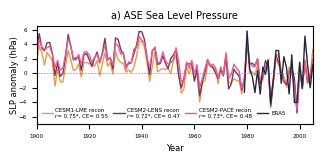

In [13]:
# Plot recon ASE SLP timeseries

shelf_tseries = []
lat1,lat2,lon1,lon2 = [-70,-76,-115,-100] #ASE near plotting domain
recon_data_dict = recon_psl_dict

fig,ax = plt.subplots()
fig.set_size_inches((3.25,1.5))
recon_years = recon_tas_dict[lab].time
fs = 8
colors = ["#e69b4b","#753669","#ED5A8D","#23293d"]

# get ERA5 rel to 1979-2005
era_fname = 'Climate_Data/ERA5/ERA5_annual_1979_2023_psl.nc'
ds = xr.open_dataset(era_fname)
ds = ds.isel(expver=0)
era_data = ds.get('psl')/100
# era lat 90,...-90. lon -180,...,180.
era_data_reg = era_data.sel(latitude = slice(lat1,lat2),longitude=slice(lon1,lon2))
era_data_tseries = era_data_reg.mean(dim='longitude')
era_data_tseries = era_data_tseries.mean(dim='latitude')
era_data_ref = np.mean(era_data_tseries.sel(time=slice('1979','2005')))
era_data_anom = era_data_tseries - era_data_ref
era_years = np.arange(1979,2024,1)

# get recons
for lab,color in zip(labs,colors):

    recon_data = recon_data_dict[lab]
    
    # calculate regional data
    recon_reg = recon_data.sel(lat=slice(lat2,lat1),lon=slice(180+(180+lon1),180+(180+lon2)))
    recon_reg = recon_reg.squeeze()
    recon_tseries = recon_reg.mean(dim='lon')
    recon_tseries = recon_tseries.mean(dim='lat')

    # calculate 1900-2005 trend and 1940s mag
    slope, intercept, r_value, p_value, std_err = stats.linregress(recon_years, recon_tseries)
    mag_1940s = np.mean(recon_tseries.sel(time=slice(1940,1941)))
    print(lab+'\n20th century trend: {:.2f}'.format(slope*100)+'hPa/cent, p={:.5f}'.format(p_value))
    print('1940s magnitude: {:2f}'.format(mag_1940s)+' hPa')

    # calculate stats with ERA5
    start_idx = np.where(recon_years == 1979)[0][0]
    corr, sig = calc_corr(recon_tseries[start_idx:],era_data_anom[0:27])
    ce = calc_ce(recon_tseries[start_idx:],era_data_anom[0:27])
    stat_str_run = lab+'\nr= '+str(corr)+sig+', CE= '+ce

    # format label
    # uncomment to add trends to legend
    legend_lab = stat_str_run#+'\n {:.2f} m/s/cent'.format(slope*100) + '\n{:.2f} m/s'.format(mag_1940s)
    
    #plot
    ax.plot(recon_years,recon_tseries,label=legend_lab,linewidth=1,color=color)

# Plot ERA5
ax.plot(era_years,era_data_anom,label='ERA5',color=colors[-1],linewidth=1)
# plot 0 line
ax.plot(np.arange(1850,2006,1),[0]*156,linestyle='--',color='gray',linewidth=0.4)

# format plot
ax.set_xlabel('Year',fontsize=fs-2)
ax.set_ylabel('SLP anomaly (hPa)',fontsize=fs-2,labelpad=-0.2)
ax.set_title('a) ASE Sea Level Pressure',fontsize=fs-1)
ax.set_xlim([1900,2005])
# ax.legend(loc='lower right', fontsize=fs-4, bbox_to_anchor=(1.3,-0.01), 
#           ncol=1, columnspacing=0.9, handletextpad=0.5, frameon=False)
ax.legend(loc='lower left', fontsize=fs-4, #bbox_to_anchor=(1.3,-0.01), 
          ncol=4, columnspacing=0.9, handletextpad=0.5, frameon=False)
ax.set_ylim([-7,6.5])
ax.tick_params(axis='x', labelsize=fs-4)
ax.tick_params(axis='y', labelsize=fs-4)

plt.subplots_adjust(top=0.86,bottom=0.21,left=0.12,right=.97)

plt.savefig('Plots/Figure_Sx_recon_tseries_psl.png',dpi=600)


CESM1-LME recon
20th century trend: -0.63m/s/cent, p=0.00000
1940s magnitude: 1.021546 m/s
CESM2-LENS recon
20th century trend: 0.14m/s/cent, p=0.11916
1940s magnitude: 0.508397 m/s
CESM2-PACE recon
20th century trend: -0.14m/s/cent, p=0.03964
1940s magnitude: 0.412508 m/s


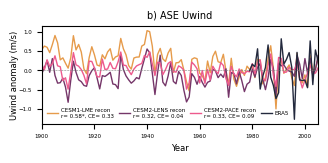

In [23]:
# Plot recon ASE U timeseries

shelf_tseries = []
# lat1,lat2,lon1,lon2 = [-70,-72,-115,-102] #shelf-break
lat1,lat2,lon1,lon2 = [-70,-76,-115,-100] #ASE near plotting domain

recon_data_dict = recon_u10_dict

fig,ax = plt.subplots()
fig.set_size_inches((3.25,1.5))
recon_years = recon_tas_dict[lab].time
fs = 8
colors = ["#e69b4b","#753669","#ED5A8D","#23293d"]

# get ERA5 rel to 1979-2005
era_fname = 'Climate_Data/ERA5/ERA5_annual_1979_2023_u10.nc'
ds = xr.open_dataset(era_fname)
ds = ds.isel(expver=0)
era_data = ds.get('u10')
# era lat 90,...-90. lon -180,...,180.
era_data_reg = era_data.sel(latitude = slice(lat1,lat2),longitude=slice(lon1,lon2))
era_data_tseries = era_data_reg.mean(dim='longitude')
era_data_tseries = era_data_tseries.mean(dim='latitude')
era_data_ref = np.mean(era_data_tseries.sel(time=slice('1979','2005')))
era_data_anom = era_data_tseries - era_data_ref
era_years = np.arange(1979,2024,1)

# get recons
for lab,color in zip(labs,colors):

    recon_data = recon_data_dict[lab]
    
    # calculate regional data
    recon_reg = recon_data.sel(lat=slice(lat2,lat1),lon=slice(180+(180+lon1),180+(180+lon2)))
    recon_reg = recon_reg.squeeze()
    recon_tseries = recon_reg.mean(dim='lon')
    recon_tseries = recon_tseries.mean(dim='lat')

    # calculate 1900-2005 trend and 1940s mag
    slope, intercept, r_value, p_value, std_err = stats.linregress(recon_years, recon_tseries)
    mag_1940s = np.mean(recon_tseries.sel(time=slice(1940,1941)))
    print(lab+'\n20th century trend: {:.2f}'.format(slope*100)+'m/s/cent, p={:.5f}'.format(p_value))
    print('1940s magnitude: {:2f}'.format(mag_1940s)+' m/s')

    # calculate stats with ERA5
    start_idx = np.where(recon_years == 1979)[0][0]
    corr, sig = calc_corr(recon_tseries[start_idx:],era_data_anom[0:27])
    ce = calc_ce(recon_tseries[start_idx:],era_data_anom[0:27])
    stat_str_run = lab+'\nr= '+str(corr)+sig+', CE= '+ce

    # format label
    # uncomment to add trends to legend
    legend_lab = stat_str_run#+'\n {:.2f} m/s/cent'.format(slope*100) + '\n{:.2f} m/s'.format(mag_1940s)
    
    #plot
    ax.plot(recon_years,recon_tseries,label=legend_lab,linewidth=1,color=color)

# Plot ERA5
ax.plot(era_years,era_data_anom,label='ERA5',color=colors[-1],linewidth=1)
# plot 0 line
ax.plot(np.arange(1850,2006,1),[0]*156,linestyle='--',color='gray',linewidth=0.4)

# format plot
ax.set_xlabel('Year',fontsize=fs-2)
ax.set_ylabel('Uwind anomaly (m/s)',fontsize=fs-2,labelpad=-0.2)
ax.set_title('b) ASE Uwind',fontsize=fs-1)
ax.set_xlim([1900,2005])
# ax.legend(loc='lower right', fontsize=fs-4, bbox_to_anchor=(1.3,-0.01), 
#           ncol=1, columnspacing=0.9, handletextpad=0.5, frameon=False)
ax.legend(loc='lower left', fontsize=fs-4, #bbox_to_anchor=(1.3,-0.01), 
          ncol=4, columnspacing=0.9, handletextpad=0.5, frameon=False)
# ax.set_ylim([-7,6.5])
ax.tick_params(axis='x', labelsize=fs-4)
ax.tick_params(axis='y', labelsize=fs-4)

plt.subplots_adjust(top=0.86,bottom=0.21,left=0.12,right=.97)

plt.savefig('Plots/Figure_Sx_recon_tseries_uwind.png',dpi=600)
